# Plug-and-play (PnP) regularisation for computed tomography (CT) inverse problem with Shepp-Logan Phantom

In [390]:
import numpy as np
import matplotlib.pyplot as plt

#CT Radon transform forward model and denoising functions
from skimage.transform import radon, resize, iradon
from skimage.data import shepp_logan_phantom


#Torch imports
import torch
import torch.nn.functional as F
from torchvision import transforms


# Deep inverse imports
import deepinv as dinv
from deepinv.models import DnCNN, DRUNet

#TV and BM3D imports with tracker
from tqdm import tqdm
from bm3d import bm3d
from utils.torch_denoise_tv_chambolle import *

#local imports (Radon transform, Gaussian noise, FBP, PSNR and PnP-PGD, PnP-FISTA, PnP-ADMM algorithms and all the plotting functions)
from radon import forward_operator_radon, add_noise, fbp
from algorithms import *
from plotting import *



#Reproducible results
torch.manual_seed(42)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
transform = transforms.Compose([transforms.ToTensor()])

In [40]:
#For plots 
import pylab as plot
params = {'legend.fontsize': 15,
          'legend.handlelength': 2,
          "font.size": 20,
          "text.usetex": True,
          "font.family": "Computer Modern Roman",
          #"label.fontsize": 18
          }
plot.rcParams.update(params)

In [3]:
#Radon transform (Forward model CT)
n = 84
n_angles = 60
phantom = resize(shepp_logan_phantom(), (n,n))
A = forward_operator_radon(n, n_angles)


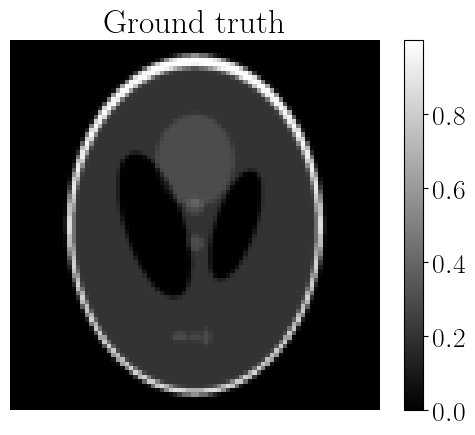

In [356]:
#Plotting the Phantom and corresponding sinogram (noise-free)
plt.imshow(phantom, cmap = 'gray')
plt.title('Ground truth')
plt.axis('off')
plt.colorbar()

In [411]:
imsize

(84, 84)

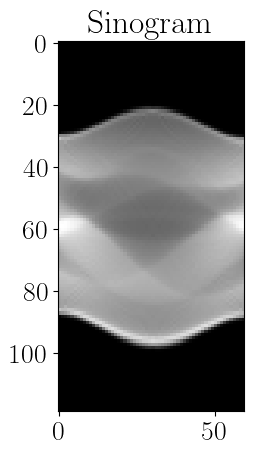

In [358]:
imsize = (n, n)
phantom = resize(shepp_logan_phantom(), (n,n))
y = np.reshape(A@phantom.flatten(), (int(np.ceil(n*np.sqrt(2))), n_angles))
plt.title("Sinogram")
plt.imshow(y, cmap='gray')
#ground truth
x = torch.from_numpy(phantom).flatten().float()


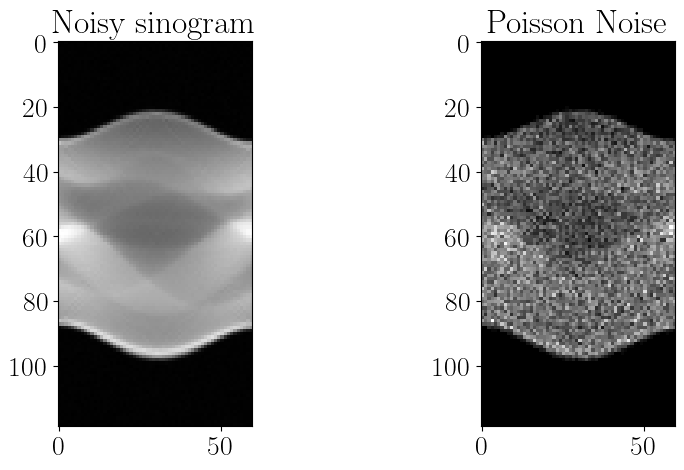

In [337]:
# Add Gaussian and Poisson noise to the sinogram
sigma = 0.05 #Typical noise levels range from 0.01-0.1 (5% of the maximum intensity of the ground truth image)
gauss_y = add_noise(y, noise_type='gaussian', sigma = sigma).float()
poisson_y = add_noise(y, noise_type='poisson').float()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Noisy sinogram")
plt.imshow(gauss_y.numpy(), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Poisson Noise")
plt.imshow(poisson_y.numpy(), cmap='gray')

Text(0.5, 1.0, 'Noise-free FBP reconstruction')

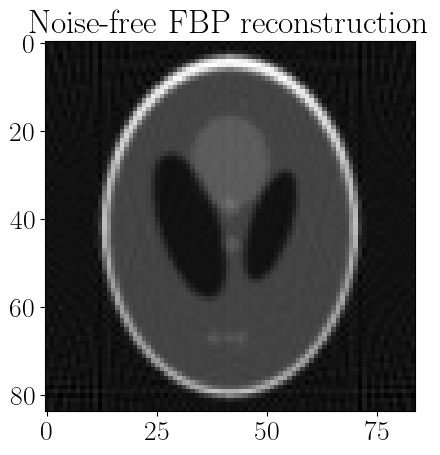

In [357]:
#Noise free FBP
reconstruction_fbp = fbp(y, n_angles)
plt.imshow(reconstruction_fbp, cmap='gray')
plt.title('Noise-free FBP reconstruction')


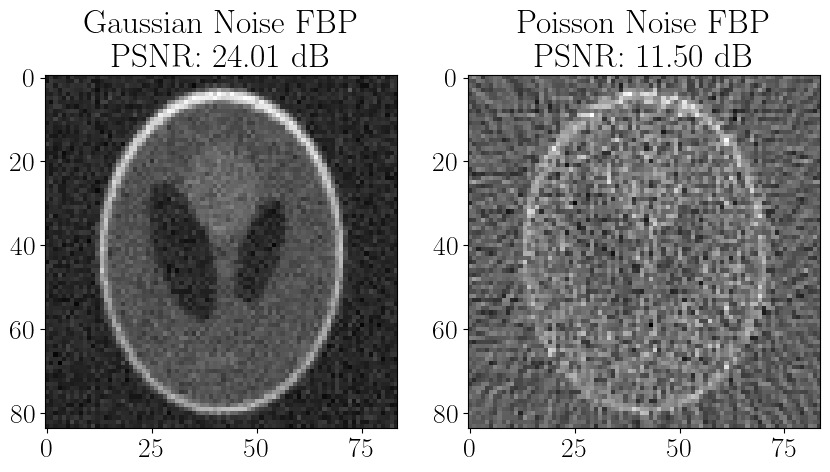

In [338]:
#Noisy reconstruction
s = 0.05
gfbp = fbp(gauss_y, n_angles)
pfbp = fbp(poisson_y, n_angles)
gfbp =  gfbp.reshape(n, n) + torch.randn(n,n)*s
g_psnr = PSNR(x, gfbp)
p_psnr = PSNR(x, pfbp)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f"Gaussian Noise FBP \n PSNR: {g_psnr:.2f} dB")
plt.imshow(gfbp, cmap='gray')

plt.subplot(1, 2, 2)
plt.title(f"Poisson Noise FBP \n PSNR: {p_psnr:.2f} dB")
plt.imshow(pfbp, cmap='gray')

# Deep denoisers (DnCNN, DRUNet, GS-DRUNet) - imported from algorithms.py

In [359]:
#Deep denoisers
channels = 1
# DnCNN Zhang 2017 denoiser
dncnn = DnCNN(
    in_channels=channels,
    out_channels=channels,
    pretrained="download",  
    device="cpu",
)

# Zhang 2021 denoiser
drunet = DRUNet(
    in_channels= channels,
    out_channels= channels,
    pretrained="download",
    device="cpu",
)



In [360]:
gsdrunet = GSDRUNet(
    in_channels= 1,
    out_channels= 1,
    pretrained="download",
    device="cpu",
)

#gsdrunet(x.reshape(imsize).unsqueeze(0).unsqueeze(0), sigma = sigma)

# Five denoiser choices for the proximal operator - can be imported from algorithms.py

In [361]:
def soft_thresh(x, l):
    return torch.sign(x) * F.relu(torch.abs(x) - l)

def apply_denoiser(x, l, sigma = sigma,  method = 'tv'):
        """
        Denoiser options to replace the proximal step
        """
        if method == 'tv':
            return denoise_tv_chambolle_torch(x, weight = l)
        elif method == 'bm3d':
            #x = torch.to_numpy(x)
            #print(x.shape)
            x = bm3d(x.reshape(imsize), sigma_psd = sigma*5).flatten()
            return torch.from_numpy(x).float()
        elif method == 'proximal':
            return soft_thresh(x, l)
        elif method == 'DnCNN':
            #print('DnCNN')
            x = x.unsqueeze(0).unsqueeze(0)
            x = dncnn(x)
            return x.squeeze(0).squeeze(0)
        elif method == 'DRUNet':
            x = x.reshape(imsize)
            x = x.unsqueeze(0).unsqueeze(0)
            x = drunet(x, sigma = sigma)
            return x.squeeze(0).squeeze(0).flatten().detach()
        elif method == "GS-DRUNet":
            x = x.reshape(imsize)
            #print("x shape before:", x.shape)
            x = x.unsqueeze(0).unsqueeze(0)
            #print("x shape after:", x.shape)
            x = gsdrunet(x, sigma = sigma)
            x =  x.squeeze(0).squeeze(0)
            return x.flatten().detach()


# PnP-PGD and PnP-FISTA with Lipschitz constant upper bound estimated (power method)

In [362]:
#Upper bound for Lispchitz constant (L) and in turn the upper bound for the stepsize (1/L) - where the upper bound is the largest eigenvalue of the Hessian of f(x), i.e A^T A
H = A.T @ A
ev = power_method(H)
print(f"Largest eigenvalue estimate: {ev}")

#gauss_y.shape
guess = A.T @ (gauss_y.flatten())
plt.imshow(guess.reshape(imsize), cmap= 'gray')

Largest eigenvalue estimate: 4866.83056640625


In [391]:
#Imported PnP-PGD, FISTA from algorithms.py
#a, b, c, d, e = pnp_fista(A, gauss_y, x, method = 'DnCNN', iters = 50)

PnP FISTA iterations:   2%|▏         | 1/50 [00:00<00:05,  9.14it/s]C:\Users\as5057\AppData\Local\Temp\ipykernel_28328\3378560166.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = (1 + torch.sqrt(torch.tensor(1 + 4 * t ** 2))) / 2.
PnP FISTA iterations: 100%|██████████| 50/50 [00:04<00:00, 10.91it/s]

PnP-DnCNN Final PSNR: 30.57 dB


In [60]:
#BM3D denoiser
x_bm3d, bm3dr, bm3diff, bm3dpairs, bm3dincr = pnp_pgd(A, gauss_y, x, method = 'bm3d', iters = 200, sigma = 1e-4)
#xf_bm3d, fbm3dr, fbm3diff, fbm3dpairs, fbm3dincr = pnp_fista(A, gauss_y, x, method = 'bm3d', iters = 200)

bm3d-PnP PGD iterations: 100%|██████████| 200/200 [04:50<00:00,  1.45s/it]

PnP-bm3d Final PSNR: 31.32 dB


# PnP-PGD - TV, DnCNN and DRUNet

In [392]:
iters = 200
x_prox, proxr, proxdiff, proxpairs, proxincr = pnp_pgd(A, gauss_y, x, method = 'proximal', reg_l = 5e-4, iters = iters, sigma = sigma)
x_tv, tvr, tvdiff, tvpairs, tvincr = pnp_pgd(A, gauss_y, x, method = 'tv', reg_l = 5e-4, iters = iters, sigma = sigma)

proximal-PnP PGD iterations: 100%|██████████| 200/200 [00:04<00:00, 48.68it/s]


PnP-proximal Final PSNR: 33.01 dB


tv-PnP PGD iterations: 100%|██████████| 200/200 [00:04<00:00, 46.00it/s]


PnP-tv Final PSNR: 29.73 dB


In [796]:
"""
p = 0
bl = 0
for l in [2900, 3000, ev]:
    x_tv, tvr, tvdiff, tvpairs, tvincr = pnp_pgd(A, gauss_y, x, method = 'tv', iters = 200)
    #x_drunet, drur, drudiff, drupairs, druincr = pnp_pgd(A, gauss_y, x, method = 'GS-DRUNet', iters = 50, L= l)
    if drur[-1] >= p:
        p = drur[-1]
        bl = l 

print("Best PSNR:", p, " with best stepsize:", bl)
"""

tv-PnP PGD iterations: 100%|██████████| 200/200 [00:05<00:00, 35.43it/s]


PnP-tv Final PSNR: 32.72 dB


tv-PnP PGD iterations: 100%|██████████| 200/200 [00:04<00:00, 40.15it/s]


PnP-tv Final PSNR: 32.65 dB


tv-PnP PGD iterations: 100%|██████████| 200/200 [00:05<00:00, 37.33it/s]

PnP-tv Final PSNR: 31.25 dB
Best PSNR: tensor(27.9898)  with best stepsize: 4866.8310546875


In [366]:
x_dncnn, cnnr, cnndiff, cnnpairs, cnnincr = pnp_pgd(A, gauss_y, x, method = 'DnCNN', iters = iters, L = 4000)
a, b, c, d, e = pnp_pgd(A, gauss_y, x, method = 'tv', reg_l = 1e-4, iters = 171, sigma = sigma)
x_dncnn = a

DnCNN-PnP PGD iterations: 100%|██████████| 200/200 [00:12<00:00, 15.63it/s]


PnP-DnCNN Final PSNR: 30.99 dB


tv-PnP PGD iterations: 100%|██████████| 171/171 [00:03<00:00, 49.16it/s]

PnP-tv Final PSNR: 31.03 dB


In [63]:
x_drunet, drur, drudiff, drupairs, druincr = pnp_pgd(A, gauss_y, x, method = 'DRUNet', iters = iters, L = 2900)
x_gs, gsr, gsdiff, gspairs, gsincr = pnp_pgd(A, gauss_y, x, method = 'GS-DRUNet', iters = iters, L = 2900)

DRUNet-PnP PGD iterations: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


PnP-DRUNet Final PSNR: 28.01 dB


GS-DRUNet-PnP PGD iterations: 100%|██████████| 200/200 [04:08<00:00,  1.24s/it]

PnP-GS-DRUNet Final PSNR: 26.68 dB


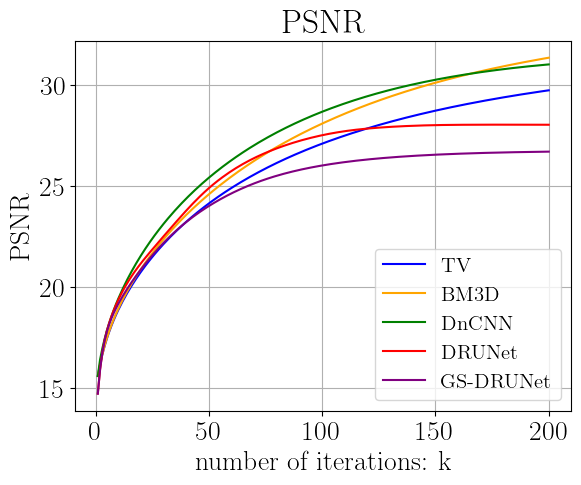

In [370]:
#Comparison of PSNRs
comparison_plot(tvr,'TV', color='b')
comparison_plot(bm3dr, 'BM3D', color='orange')
comparison_plot(cnnr,'DnCNN', color='green')
comparison_plot(drur,'DRUNet', color='red')
comparison_plot(gsr,'GS-DRUNet', color='purple')



<>:17: SyntaxWarning: invalid escape sequence '\|'
<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\|'
<>:37: SyntaxWarning: invalid escape sequence '\s'
C:\Users\as5057\AppData\Local\Temp\ipykernel_28328\3070806319.py:17: SyntaxWarning: invalid escape sequence '\|'
  ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|_2$')
C:\Users\as5057\AppData\Local\Temp\ipykernel_28328\3070806319.py:37: SyntaxWarning: invalid escape sequence '\s'
  ax2.semilogy(iterations, 5/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)
C:\Users\as5057\AppData\Local\Temp\ipykernel_28328\3070806319.py:37: RuntimeWarning: divide by zero encountered in divide
  ax2.semilogy(iterations, 5/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)


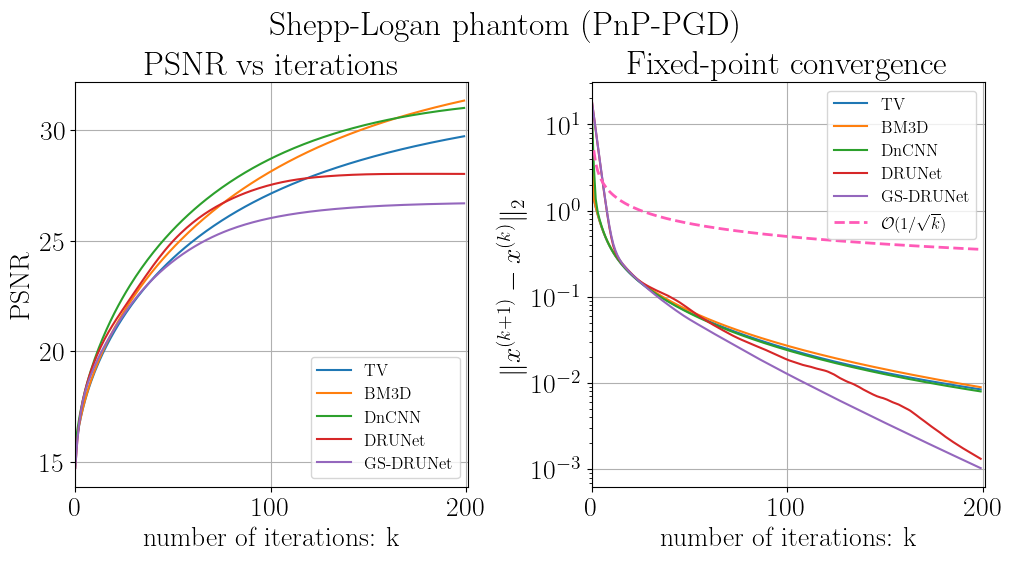

In [375]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
fig.suptitle('Shepp-Logan phantom (PnP-PGD)')
ax1.set_title('PSNR vs iterations')
ax2.set_title('Fixed-point convergence')
def plot_psnrs_differences(psnrs, diffs, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """

    #fig.suptitle(method)
    ax1.plot(range(0, len(psnrs)), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(range(0, len(diffs)),diffs, label = method)
    ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|_2$')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)
    ax1.set_xlim([0, len(psnrs) + 1])
    ax2.set_xlim([0, len(psnrs) + 1])
    
    return psnrs[-1]

tvpsnr = plot_psnrs_differences(tvr, tvincr, 'TV')
bm3dpsnr = plot_psnrs_differences(bm3dr, bm3dincr, 'BM3D')
dncnnpsnr = plot_psnrs_differences(cnnr, cnnincr, 'DnCNN')
drunetpsnr = plot_psnrs_differences(drur, druincr, 'DRUNet')
gsdrunetpsnr = plot_psnrs_differences(gsr, gsincr, 'GS-DRUNet')

psnrs_list = [PSNR(x, gfbp), tvpsnr, bm3dpsnr, dncnnpsnr, drunetpsnr, gsdrunetpsnr]

iterations = np.arange(200)

#Reference for O(1/sqrt(k)) fixed-pooint convergence for GS-DRUNet denoiser
#ax2.semilogy(iterations, 15/iterations, label = '$\\mathcal{O}(1/k)$', linestyle = '--', color = '#13A49F', linewidth = 2)
ax2.semilogy(iterations, 5/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)

ax1.legend(fontsize = 12)
ax2.legend(fontsize = 12)
plt.savefig('plots/PnPPGDPhantomgraphs.png', dpi = 300)

In [ ]:
#PnP-FISTA
#iters = 200
#xf_tv, ftvr, ftvdiff, ftvpairs, ftvincr = pnp_fista(A, gauss_y, x, method = 'tv', reg_l = 1e-5, iters = iters)
#xf_dncnn, fcnnr, fcnndiff, fcnnpairs, fcnnincr = pnp_fista(A, gauss_y, x, method = 'DnCNN', iters = iters)
#xf_drunet, fdrur, fdrudiff, fdrupairs, fdruincr = pnp_fista(A, gauss_y, x, method = 'DRUNet', sigma = lamb, iters = iters)
#x_gsf, gsf, gsdifff, gspairsf, gsrelf = pnp_fista(A, gauss_y, x, method = 'GS-DRUNet', reg_l = lamb, iters = iters)

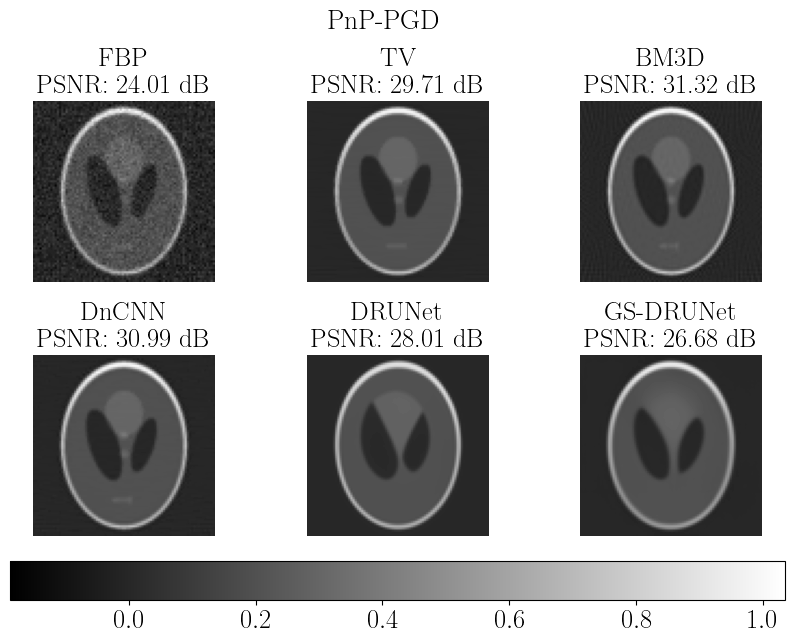

In [376]:
#plotting_estimates1(gfbp.reshape(imsize), xf_tv.reshape(imsize), xf_bm3d.reshape(imsize), xf_dncnn.reshape(imsize), xf_drunet.reshape(imsize), 1, psnrs_list, title='PnP-FISTA')
plotting_estimates1(gfbp.reshape(imsize), x_tv.reshape(imsize), x_bm3d.reshape(imsize), x_dncnn.reshape(imsize), x_drunet.reshape(imsize), x_gs.reshape(imsize), psnrs_list, title='PnP-PGD')
#plt.tight_layout()

# Residual noise distribution between iterates for the denoisers $(D(x^{(k)}) - x^{(k)})$
Kolomogrov-Smirnov test to check Gaussian shape, if any for the residual noise of the denoisers - algorithm iterates

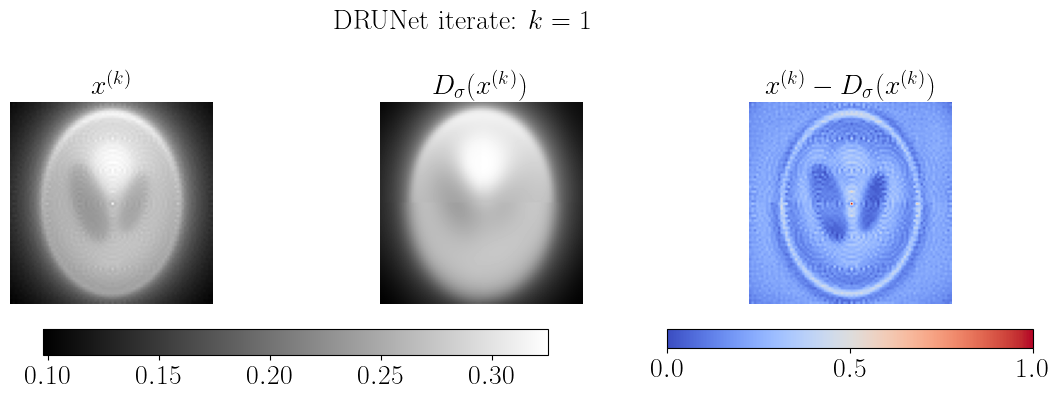

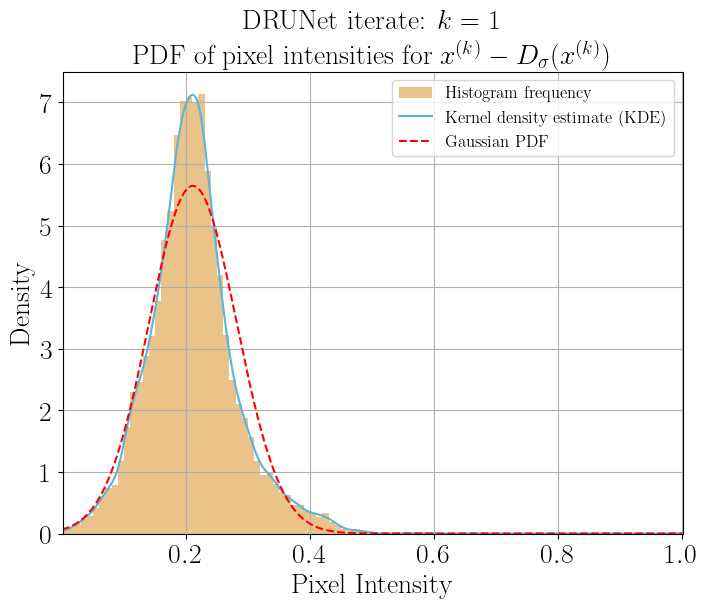

mu=0.21, std=0.07
KS Test: D-statistic=0.0609, p-value=0.0000
Anderson-Darling Test Statistic: 39.64539422955568
Critical value=0.7870
Cramér-von Mises Test Statistic: 6.7814361003528365, p-value: 1.0408685024998476e-10


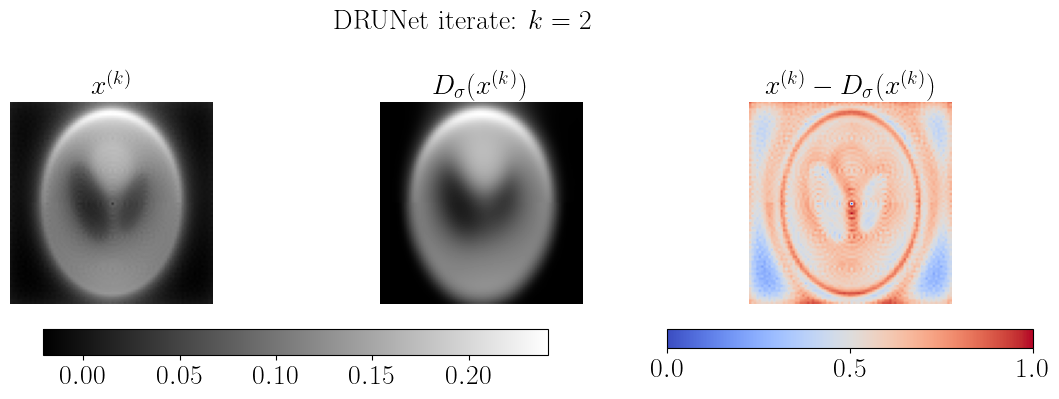

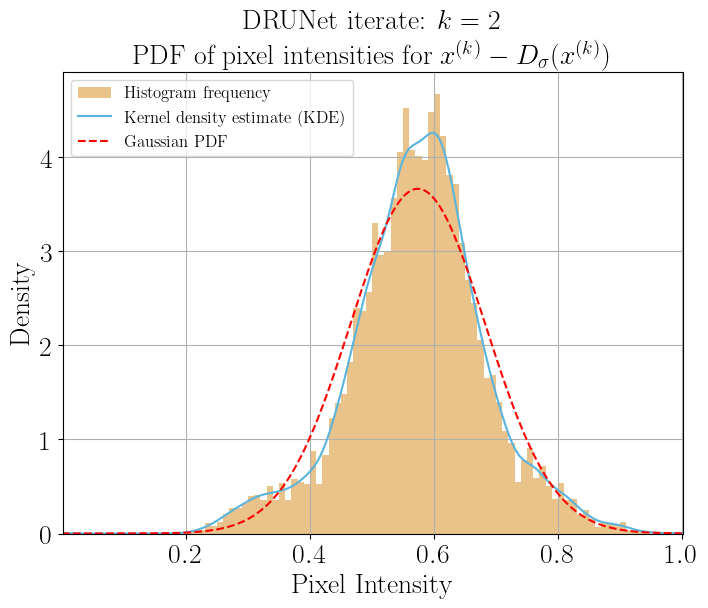

mu=0.57, std=0.11
KS Test: D-statistic=0.0369, p-value=0.0000
Anderson-Darling Test Statistic: 22.907856850436474
Critical value=0.7870
Cramér-von Mises Test Statistic: 3.567181815936871, p-value: 4.229335770489229e-09


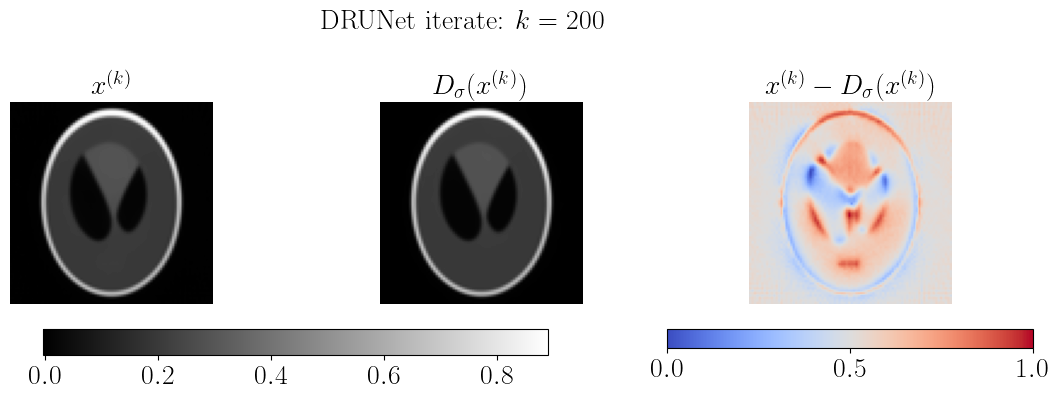

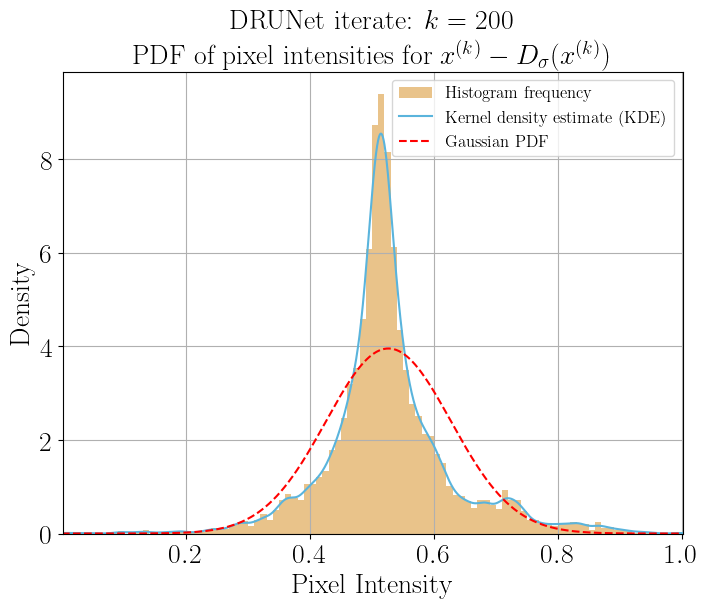

mu=0.53, std=0.10
KS Test: D-statistic=0.1222, p-value=0.0000
Anderson-Darling Test Statistic: 184.38461269824802
Critical value=0.7870
Cramér-von Mises Test Statistic: 35.77204401322687, p-value: 1.2366637047733775e-08


In [389]:
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kstest, cramervonmises, anderson, norm, ecdf
def pdf_plot(noise_diff, iterates_pairs, iteration, title):
    """
    Plotting the differences between inverted and denoised iterates of x^(k)
    """
    fontsize = 20
    fig1, axs = plt.subplots(1, 3, figsize=(12, 4))
    noised_x = iterates_pairs[iteration][0].reshape(imsize)
    denoised_x = iterates_pairs[iteration][1].reshape(imsize)
    noise_diff = (noise_diff - torch.min(noise_diff))/(torch.max(noise_diff) - torch.min(noise_diff))
    #normalise 2nd colorbar
    #dmin = noise_diff.min()
    #dmax = noise_diff.max()

    fig1.suptitle(title + str(iteration + 1), fontsize = fontsize)
    im1 = axs[0].imshow(noised_x, cmap = 'gray')
    im2 = axs[1].imshow(denoised_x, cmap = 'gray')
    im3 = axs[2].imshow(noise_diff.reshape(imsize), cmap = 'coolwarm')

    axs[0].set_title('$x^{(k)}$', fontsize = fontsize)
    axs[1].set_title('$D_{\\sigma}(x^{(k)})$', fontsize = fontsize)
    axs[2].set_title('$x^{(k)} - D_{\\sigma}(x^{(k)})$', fontsize = fontsize)
    plt.tight_layout()

    for i in range(3):
        axs[i].axis('off')

 
    #cbar_ax1 = fig1.add_axes([0.1, -0.05, 0.4, 0.02])  # Colorbar for the first two plots
    #cbar_ax2 = fig1.add_axes([0.55, -0.05, 0.4, 0.02])  # Colorbar for the third plot
    
    plt.subplots_adjust(wspace=0.01, hspace=0.1)
    cbar1 = fig1.colorbar(im1, ax=axs[:2], orientation='horizontal', fraction=0.1, pad=0.1)
    #cbar1.set_ticks([0.0, 0.25, 0.50, 0.75, 1.0]) 
    
    cbar2 = fig1.colorbar(im3, ax=axs[2], orientation='horizontal', fraction=0.1, pad=0.1)
    cbar2.set_ticks([0, 0.5, 1])  
    
    
    
    plt.show()

    #Normalising the pixel values
    noise_diff = (noise_diff - torch.min(noise_diff))/(torch.max(noise_diff) - torch.min(noise_diff))
    #noise_diff = (noise_diff - torch.mean(noise_diff))/(torch.std(noise_diff))
    noise_diff_np = noise_diff.numpy().flatten()
    iterate = title + str(iteration+1)

    #Reference gaussian pdf with same mean and standard deviation
    xrange = np.linspace(0, 1, 1000)
    mu, std = np.mean(noise_diff_np), np.std(noise_diff_np)
    gaussian_pdf = norm.pdf(xrange, loc=mu, scale=std)
    

    #Compute kernel density estimate (kde for pdf of noise distribution)
    fig2 = plt.figure(figsize=(8,6))
    kde = sm.nonparametric.KDEUnivariate(noise_diff) 
    kde.fit(bw = 'scott')

    peak_index = np.argmax(kde.density)
    peak_value = kde.support[peak_index]
    
    plt.hist(noise_diff, density = True, bins = 100, alpha = 0.5, color="#D58817", label = 'Histogram frequency', weights=np.ones_like(noise_diff) / len(noise_diff))
    plt.plot(kde.support, kde.density, color="#5AB4DC", label = 'Kernel density estimate (KDE)')
    plt.plot(xrange, gaussian_pdf, label='Gaussian PDF', color='red', linestyle='--')
    #sns.kdeplot(noise_diff.numpy(), fill = True, color='g')

    plt.xlim([0.001, 1.001])
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    plt.title(iterate + " \n PDF of pixel intensities for $x^{(k)} - D_{\\sigma}(x^{(k)})$", fontsize = fontsize)
    plt.grid(True)
    plt.legend(fontsize = 12)
    
    plt.show()
    
    
    D, p_value = kstest(noise_diff_np, 'norm', args=(mu, std))
    print(f'mu={mu:.2f}, std={std:.2f}')
    print(f'KS Test: D-statistic={D:.4f}, p-value={p_value:.4f}')
    

    result = anderson(noise_diff_np, dist='norm')

    # Get the critical value for the 5% significance level
    critical = result.critical_values[2] 
    print(f'Anderson-Darling Test Statistic: {result.statistic}')
    print(f'Critical value={critical:.4f}')

    result = cramervonmises(noise_diff_np, cdf='norm', args=(mu, std))
    print(f'Cramér-von Mises Test Statistic: {result.statistic}, p-value: {result.pvalue}')
    
    

    
    
shift = 0
iterates = [0, 1, 199]
#PnP-pgd 
for i in iterates:
    #pdf_plot(proxdiff[i+shift], proxpairs, iteration = i+shift, title = "Prox iterate: $k=$ ")
    #pdf_plot(tvdiff[i+shift], tvpairs, iteration = i+shift, title = "TV iterate: $k=$ ")
    #pdf_plot(bm3diff[i+shift], bm3dpairs, iteration = i+shift, title = "BM3D iterate: $k=$ ")
    #pdf_plot(cnndiff[i+shift], cnnpairs, iteration = i+shift, title = "DnCNN iterate: $k=$ ")
    pdf_plot(drudiff[i+shift], drupairs, iteration = i+shift, title = "DRUNet iterate: $k=$ ")
    #pdf_plot(gsdiff[i+shift], gspairs, iteration = i+shift, title = "GS-DRUNet iterate: $k=$ ")
    

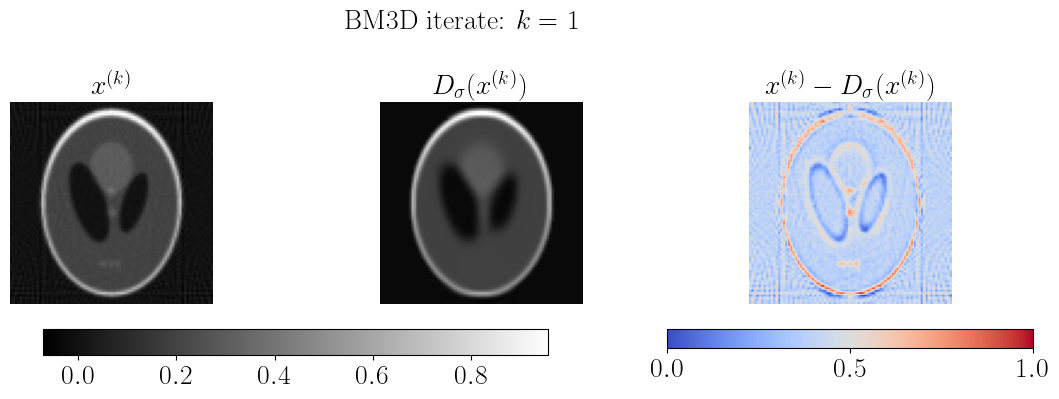

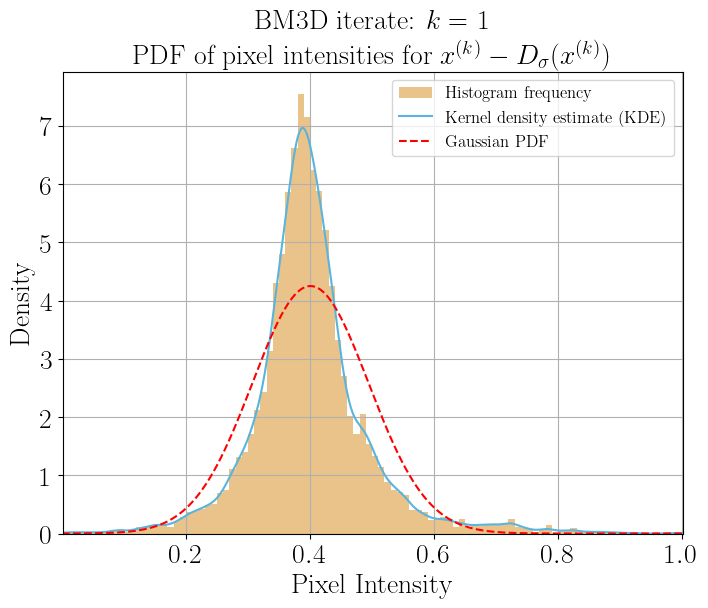

mu=0.40, std=0.09
KS Test: D-statistic=0.1041, p-value=0.0000
Anderson-Darling Test Statistic: 142.35388926877567
Critical value=0.7870
Cramér-von Mises Test Statistic: 25.37926093198655, p-value: 3.855447405776147e-09


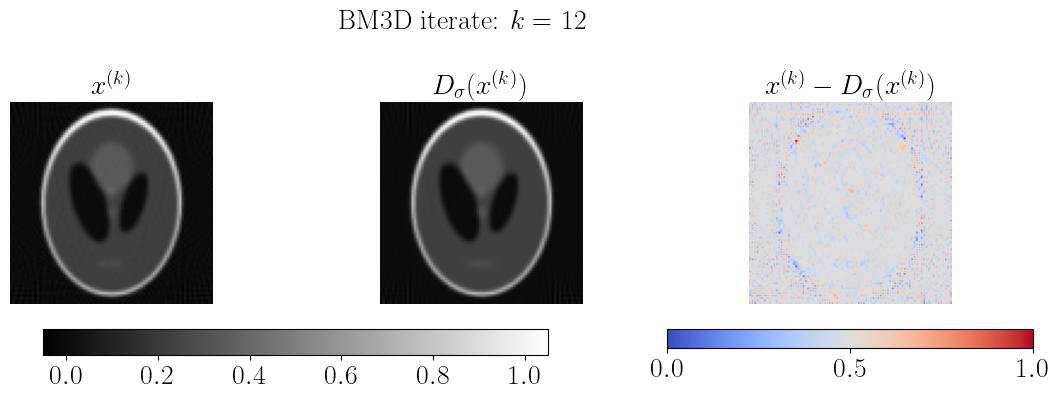

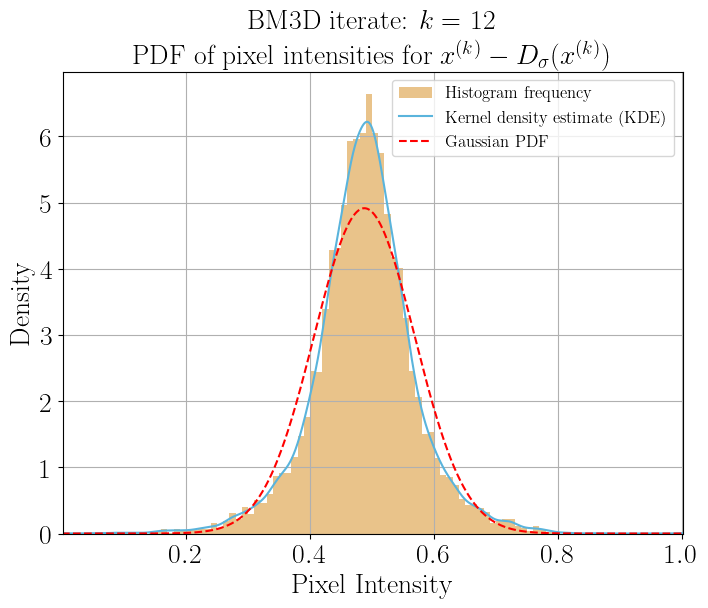

mu=0.49, std=0.08
KS Test: D-statistic=0.0472, p-value=0.0000
Anderson-Darling Test Statistic: 39.63718266274191
Critical value=0.7870
Cramér-von Mises Test Statistic: 6.601910421727864, p-value: 6.027744969827609e-11


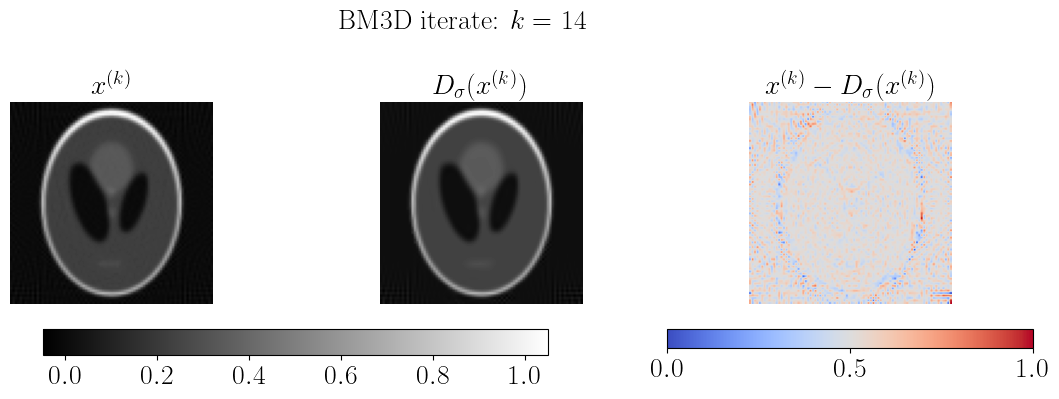

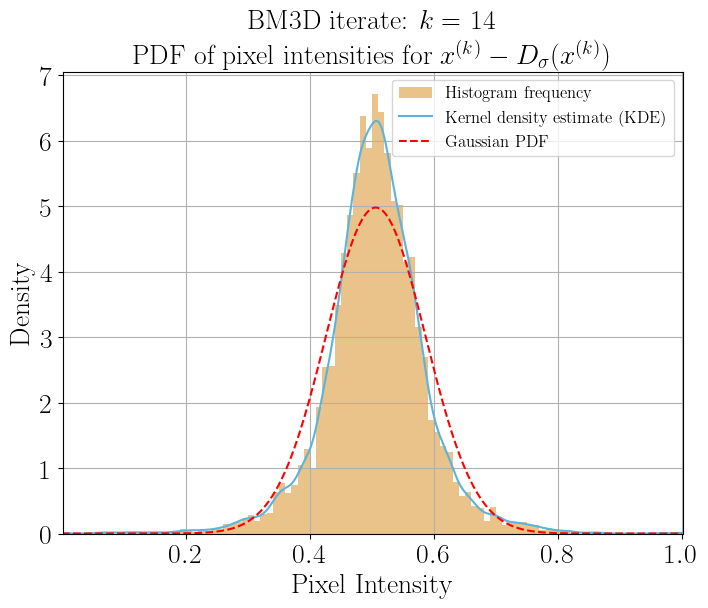

mu=0.51, std=0.08
KS Test: D-statistic=0.0557, p-value=0.0000
Anderson-Darling Test Statistic: 48.08439568518406
Critical value=0.7870
Cramér-von Mises Test Statistic: 7.7357502646720375, p-value: 1.2428333917569034e-09


In [385]:
#PnP-ADMM (run the below code first for PnP-ADMM)
shift = 0
iterates = [0, 1,  199]
for i in [0, 11, 13]:
    #pdf_plot(aproxdiff[i+shift], aproxpairs, iteration = i+shift, title = "Prox iterate: $k=$ ")
    #pdf_plot(atvdiff[i+shift], atvpairs, iteration = i+shift, title = "TV iterate: $k=$ ")
    #pdf_plot(acnndiff[i+shift], adncnnpairs, iteration = i+shift, title = "DnCNN iterate: $k=$ ")
    #pdf_plot(adrudiff[i+shift], adrupairs, iteration = i+shift, title = "DRUNet iterate: $k=$ ")
    pdf_plot(abm3diff[i+shift], abm3dpairs, iteration = i, title = "BM3D iterate: $k=$ ")

In [407]:
m = A.shape[0]
detectors = m//60
detectors

119

# PnP-ADMM

In [408]:
#PnP-ADMM imported from algorithms.py

In [ ]:
i = 50
#admm_prox, aproxpsnr, aproxdiff, aproxpairs, aproxincr = pnp_admm(A, gauss_y, x, 'proximal', niter = i, beta = 10, lamb = 1)
admm_bm3d, abm3dpsnr, abm3diff, abm3dpairs, abm3dincr = pnp_admm(A, gauss_y, x, 'bm3d', niter = iters)


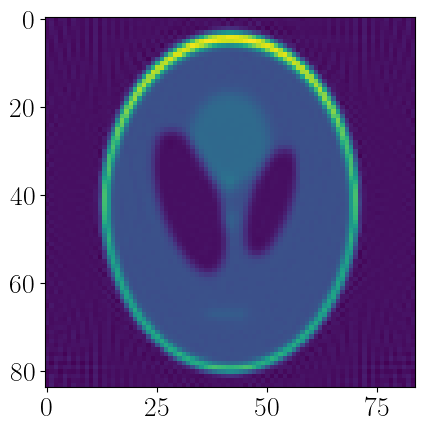

In [410]:
plt.imshow(admm_bm3d.reshape(n,n))

In [409]:
admm_tv, atvpsnr, atvdiff, atvpairs, atvincr = pnp_admm(A, gauss_y, x, 'tv', niter = 50, lamb= 1e-1, beta = 6)

tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:01<00:00, 30.61it/s]

Final PSNR: 25.95 dB


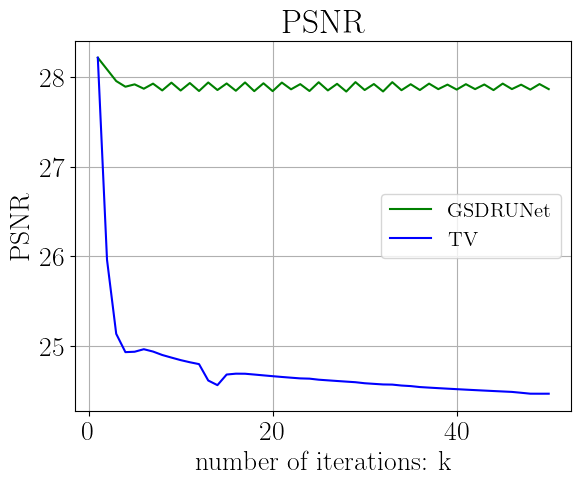

In [209]:
comparison_plot(agsdrunetpsnr, 'GSDRUNet', color= 'green')
comparison_plot(atvpsnr, 'TV', color= 'blue')

In [145]:
iters = 50
#admm_prox, aproxpsnr, aproxdiff, aproxpairs, aproxincr = pnp_admm(A, gauss_y, x, 'proximal', niter = iters, beta = 10, lamb = 1)

admm_dncnn, adncnnpsnr, acnndiff, adncnnpairs, adncnnincr  = pnp_admm(A, gauss_y, x, 'DnCNN', niter = iters)
admm_dru, adrunetpsnr, adrudiff, adrupairs, adruincr = pnp_admm(A, gauss_y, x, 'DRUNet', niter = iters, sigma= sigma)



DnCNN-PnP ADMM iterations: 100%|██████████| 50/50 [00:05<00:00,  9.83it/s]


Final PSNR: 27.79 dB


DRUNet-PnP ADMM iterations: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]

Final PSNR: 27.88 dB


In [146]:
admm_gsdru, agsdrunetpsnr, agsdrudiff, agsdrupairs, agsdruincr = pnp_admm(A, gauss_y, x, 'GS-DRUNet', niter = iters, sigma = sigma)

GS-DRUNet-PnP ADMM iterations: 100%|██████████| 50/50 [01:00<00:00,  1.20s/it]

Final PSNR: 27.87 dB


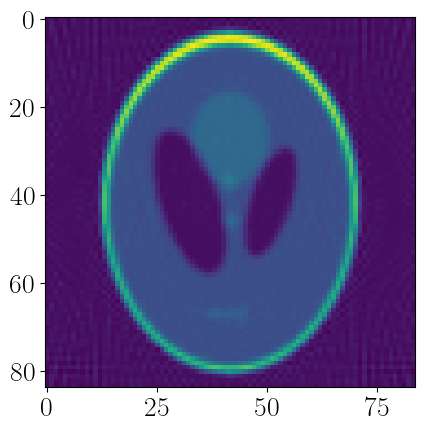

In [918]:
#plt.imshow(admm_dncnn.reshape(n,n))
plt.imshow(admm_dru.reshape(n,n))

In [877]:
admm_gsdru, agsdrunetpsnr, agsdrudiff, agsdrupairs, agsdruincr = pnp_admm(A, gauss_y, x, 'GS-DRUNet', niter = 35)

GS-DRUNet-PnP ADMM iterations: 100%|██████████| 35/35 [00:37<00:00,  1.06s/it]

Final PSNR: 27.70 dB


In [ ]:
#Searching for best lambda and beta
lambdas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1]
betas = [1e+2, 1e+1]
best = 0
b_lamb, b_beta = 0, 0
for lamb in lambdas:
    for beta in betas:
        tv, tvp, tvd, tvpairs = pnp_admm(A, gauss_y, x, 'tv', niter = iters, beta = beta, lamb= lamb)
        if tvp[-1] > best:
            best = tvp[-1]
            b_lamb, b_beta = lamb, beta

print("Best beta:", b_beta, "\n Best lambda:", b_lamb)
beta = 1e+1
lamb = 1


<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
C:\Users\as5057\AppData\Local\Temp\ipykernel_28328\1425178006.py:16: SyntaxWarning: invalid escape sequence '\s'
  ax2.semilogy(iterations, 14/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)
C:\Users\as5057\AppData\Local\Temp\ipykernel_28328\1425178006.py:16: RuntimeWarning: divide by zero encountered in divide
  ax2.semilogy(iterations, 14/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)


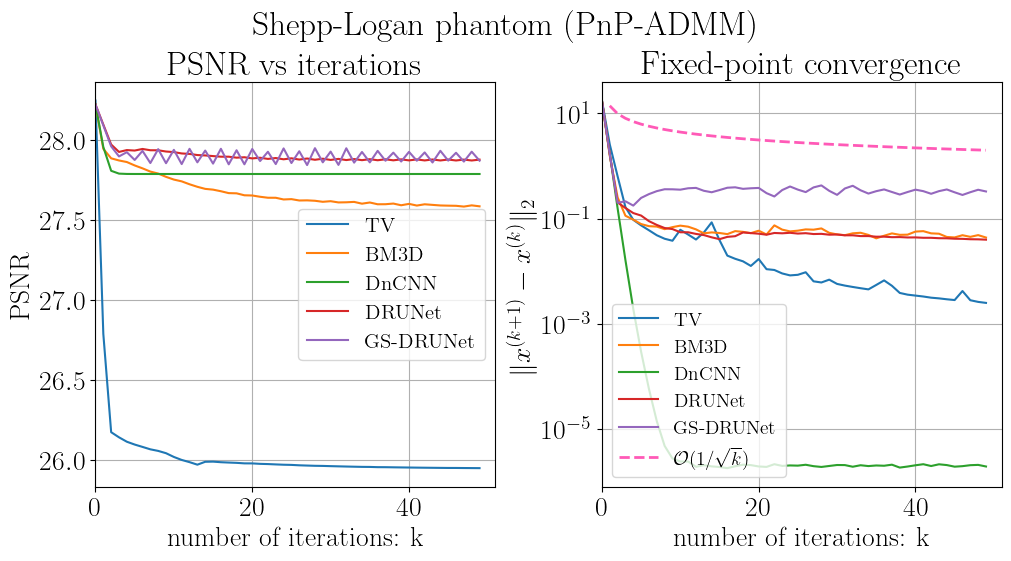

In [387]:
#Main plotting and reconstruction functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
fig.suptitle('Shepp-Logan phantom (PnP-ADMM)')
ax1.set_title('PSNR vs iterations')
ax2.set_title('Fixed-point convergence')

#proxpsnr = plot_psnrs_differences(aproxpsnr, aproxincr, 'Prox')
tvpsnr = plot_psnrs_differences(atvpsnr, atvincr, 'TV')
bm3dpsnr = plot_psnrs_differences(abm3dpsnr, abm3dincr, 'BM3D')
dncnnpsnr = plot_psnrs_differences(adncnnpsnr, adncnnincr, 'DnCNN')
drunetpsnr = plot_psnrs_differences(adrunetpsnr, adruincr, 'DRUNet')
gsdrunetpsnr = plot_psnrs_differences(agsdrunetpsnr, agsdruincr, 'GS-DRUNet')
iterations = np.arange(50)

#ax2.semilogy(iterations, 80/iterations, label = '$\\mathcal{O}(1/k)$', linestyle = '--', color = '', linewidth = 2)
ax2.semilogy(iterations, 14/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)

psnrs_list = [PSNR(x, gfbp), tvpsnr, bm3dpsnr, dncnnpsnr, drunetpsnr, gsdrunetpsnr]

ax1.legend()
ax2.legend(fontsize = 14, loc = 'best')
plt.savefig('plots/PnPADMMPhantomGraphs.png', dpi = 300)

In [162]:
imsize = (n, n)

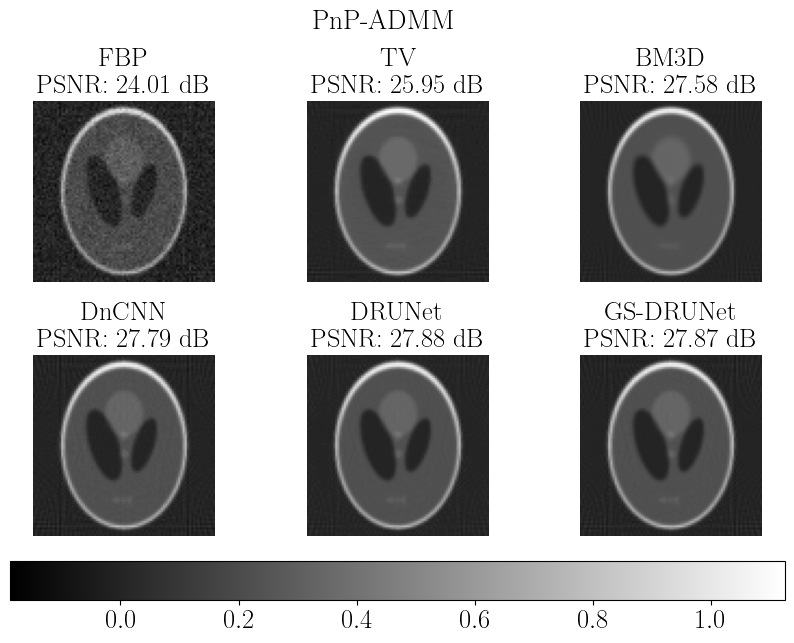

In [388]:
plotting_estimates1(gfbp.reshape(imsize), admm_tv.reshape(imsize), admm_bm3d.reshape(imsize), admm_dncnn.reshape(imsize), admm_dru.reshape(imsize), admm_gsdru.reshape(imsize), psnrs_list, title='PnP-ADMM')

## Different hypothesis tests to check the Gaussian shape of the algorithm iterates (pdf plot function above uses Kolomogrob-Smirnov test)

In [304]:
def ks_test(residual_noise, method):
    """
    Performs Kolmogorov-Smirnov (KS) hypothesis test to 5% significance level (whether the residual noise distribution for the denoiser is the shape of a Gaussian)
    """
    total = 0
    length = len(residual_noise)
    for i in range(length):
        w = residual_noise[i]
        noise_diff = (w - torch.min(w))/(torch.max(w) - torch.min(w)) #normalise
        noise_diff_np = noise_diff.numpy().flatten()
        #ks test
        mu, std = np.mean(noise_diff_np), np.std(noise_diff_np)
        D, p_value = kstest(noise_diff_np, 'norm', args=(mu, std)) #KS test with mu and std from the residual noise
        #print(f'{i:}th iteration, KS Test: D-statistic={D:.4f}, p-value={p_value:.4f}')
        if p_value >= 0.05:
            print(i)
            total +=1
    
    print("Number of null hypothesis for ", method, " accepted:", total)


#Anderson-Darling
def ad_test(residual_noise, method):
    """
    Performs Anderson-Darling hypothesis test to 5% significance level (whether the residual noise distribution for the denoiser is the shape of a Gaussian)
    """
    total = 0
    length = len(residual_noise)
    for i in range(length):
        w = residual_noise[i]
        noise_diff = (w - torch.min(w))/(torch.max(w) - torch.min(w)) #normalise
        noise_diff_np = noise_diff.numpy().flatten()
        #ks test
        result = anderson(noise_diff_np, dist = 'norm')
        if result.statistic <= result.critical_values[2]:
            print(i)
            total +=1
    
    print("Number of null hypothesis for ", method, " accepted:", total)


#Cramer von Misces
def cvm_test(residual_noise, method):
    """
    Performs Cramer Von-Misces hypothesis test to 5% significance level (whether the residual noise distribution for the denoiser is the shape of a Gaussian)
    """
    total = 0
    length = len(residual_noise)
    for i in range(length):
        w = residual_noise[i]
        noise_diff = (w - torch.min(w))/(torch.max(w) - torch.min(w)) #normalise
        noise_diff_np = noise_diff.numpy().flatten()
        mu, std = np.mean(noise_diff_np), np.std(noise_diff_np)
        
        #ks test
        result = cramervonmises(noise_diff_np, cdf='norm', args=(mu, std))
        if result.pvalue >= 0.025:
            print(i)
            total +=1
    
    print("Number of null hypothesis for ", method, " accepted:", total)
    
 

Checking how many hypothesis tests are accepted for the algorithm iterates

In [240]:
ks_test(tvdiff, "TV")
ks_test(bm3diff, "BM3D")
ks_test(cnndiff, "DnCNN")
ks_test(drudiff, "DRUNet")
ks_test(gsdiff, "GS-DRUNet")


ks_test(atvdiff, "TV")
ks_test(abm3diff, "BM3D")
ks_test(acnndiff, "DnCNN")
ks_test(adrudiff, "DRUNet")
ks_test(agsdrudiff, "GS-DRUNet")


Number of null hypothesis for  TV  accepted: 0
Number of null hypothesis for  BM3D  accepted: 0
Number of null hypothesis for  DnCNN  accepted: 0
Number of null hypothesis for  DRUNet  accepted: 0
Number of null hypothesis for  GS-DRUNet  accepted: 0
11
13
Number of null hypothesis for  TV  accepted: 2
Number of null hypothesis for  BM3D  accepted: 0
Number of null hypothesis for  DnCNN  accepted: 0
Number of null hypothesis for  DRUNet  accepted: 0
Number of null hypothesis for  GS-DRUNet  accepted: 0


In [305]:
cvm_test(tvdiff, "TV")
cvm_test(bm3diff, "BM3D")
cvm_test(cnndiff, "DnCNN")
cvm_test(drudiff, "DRUNet")
cvm_test(gsdiff, "GS-DRUNet")


cvm_test(atvdiff, "TV")
cvm_test(abm3diff, "BM3D")
cvm_test(acnndiff, "DnCNN")
cvm_test(adrudiff, "DRUNet")
cvm_test(agsdrudiff, "GS-DRUNet")

Number of null hypothesis for  TV  accepted: 0
Number of null hypothesis for  BM3D  accepted: 0
Number of null hypothesis for  DnCNN  accepted: 0
Number of null hypothesis for  DRUNet  accepted: 0
Number of null hypothesis for  GS-DRUNet  accepted: 0
11
13
Number of null hypothesis for  TV  accepted: 2
Number of null hypothesis for  BM3D  accepted: 0
Number of null hypothesis for  DnCNN  accepted: 0
Number of null hypothesis for  DRUNet  accepted: 0
Number of null hypothesis for  GS-DRUNet  accepted: 0
